In [1]:
import os
import torch
import warnings
import numpy as np
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import neptune
from matplotlib import pyplot as plt

[neptune] [warning] NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/


In [6]:
!pip install torch --upgrade
!pip install triton --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install neptune-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.7/502.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.4 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=67b750f243df37de0e22aab1f9cdab3cdc75d1f0d6a8076e3f7de42639482777
  Stored in directory: /root/.cache/pip/wheels/cf/d7/1c/1d707a21e0a0323bdbfbb2f6de125ae6bb70d62aa2838df321
Successfully built bravado-core


PyTorch device setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Seed for reproducible results

In [2]:
seed = 2025
np.random.seed(seed)
np.random.default_rng(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [3]:
class PolicyNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNet, self).__init__()

        self.fc1 = nn.Linear(input_size, 32)  # First hidden layer
        self.fc2 = nn.Linear(32, 24)          # Second hidden layer
        self.fc3 = nn.Linear(24, output_size) # Output layer

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))   # ReLU activation after first layer
        x = nn.functional.relu(self.fc2(x))   # ReLU activation after second layer
        x = self.fc3(x)                       # Output layer without activation (softmax handled later)
        x = nn.functional.softmax(x, dim=1)   # Softmax to get action probabilities

        return x

In [10]:
class ReinforceNNLearber:
    def __init__(self, env, device, run, gamma=0.99, learning_rate=9.8e-4, num_episodes = 500):
        self.env = env
        self.run = run  # Store the Neptune run
        self.gamma = gamma #discount factor
        self.learning_rate = learning_rate
        self.device = device
        # Define the policy network

        #For the CartPole environment ("CartPole-v1"), the observation space is a Box with shape (4,). This means the observation is a 1D vector of 4 continuous values, which represent cart position, cart velocity, pole angle, pole velocity at the tip.
        #Thus, the number of input features is the size of the observation vector, which can be directly obtained from the shape of the observation space, as done here for gridworld
        self.INPUT_FEATURES = self.env.observation_space.shape[0]
        self.OUTPUT_FEATURES = self.env.action_space.n
        self.policy_net = PolicyNet(self.INPUT_FEATURES,self.OUTPUT_FEATURES).to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        # when initialise like this, you're telling the optimizer how large each step (or update) should be in the gradient descent process. In this case, the learning rate (self.learning_rate) controls the size of the step taken during the optimization step.
        self.num_episodes = num_episodes

    def preprocess_state(self, state):
        """
        Preprocesses the state by transforming it to tensor and adding a batch dimension.

        Args:
            state (numpy.ndarray): Input state from the environment.

        Returns:
            torch.Tensor: State tensor with batch dimension.
        """

        #convert into a pytorch tensor. then unsqueeze to add dimension to the tensor at position zero - NN in pytorch expect batched inputs, first dim batch size.
        #.to(self.device) moves the tensor to the device. Because operations on tensors in pytorch must happen on the same device.
        normalized_state = torch.as_tensor(state, dtype=torch.float32, device=self.device)
        normalized_state = normalized_state.unsqueeze(0)

        return normalized_state


    def compute_returns(self, rewards):
        """
        Computes discounted returns.

        Args:
            rewards (list): List of rewards for each time step.

        Returns:
            numpy.ndarray: Array of discounted returns.

        """

        t_steps = np.arange(len(rewards))
        r = rewards * self.gamma ** t_steps # Compute discounted rewards for each time step

        # Compute the discounted cumulative sum in reverse order and then reverse it again to restore the original order.
        r = np.cumsum(r[::-1])[::-1] / self.gamma ** t_steps

        return r
    #What I had before was less efficient but achieved same result:
    #returns = []
    # cumulative_return = 0
    # for _, _, reward, _ in reversed(episode):
    #     cumulative_return = reward + self.gamma * cumulative_return
    #     returns.insert(0, cumulative_return)


    def compute_loss(self,log_probs, returns):
        """
        Computes the policy gradient loss based on the formula.

        Args:
            log_probs (list): List of log probabilities of selected actions.
            returns (numpy.ndarray): Array of discounted returns.

        Returns:
            torch.Tensor: Computed loss.

        """

        policy_loss = []
        for log_prob, returns in zip(log_probs, returns):#pairs each element of the log_prob with the CORRESPONDING element in the returns list. Outputs an iterator of tuples each containing one element from log_prob and one element from returns.
            #zip(epilog_probsode, returns) will create tuples like this: [(log_prob1, return_1),...]
            policy_loss.append(-log_prob * returns)
            # Negative sign for gradient ascent
            #since we want to maximize the expected return but most optimizers minimize a loss function, we accumulate the negative term for each time step
            #for each time step we calculate log_prob*Gt wehich represents how much the chosen action contributed to the overall reward in terms of the log-likelihood of the action multiplied by the expected reward (how much the action contributes to the final rewards, weighted by how likely the policy was to choose that action)

        return torch.stack(policy_loss).sum()
        #we sum all the losses for the entire episode
        #torch.stack(policy_loss) takes the list of tensors stored in policy_loss and combines them into a single tensor, stacking them along a new dimension
        #.sum() is applied to the stacked tensor to sum the individual elements of the loss across the batch


    def train(self):
        self.policy_net.train()  # Ensures the network is in training mode
        episode_rewards = []
        # Main training loop that loops over each episode
        for episode in range(1, self.num_episodes + 1):
            state, _ = self.env.reset(seed=seed) # Reset the environment and get the initial state

            # Initialize empty lists to store log probabilities and rewards for the episode
            log_probs = []
            episode_reward = []

            # Loop until the episode is done
            while True:
                state = self.preprocess_state(state) # Preprocesses the state to convert it to tensor
                action_probs = self.policy_net(state) # Forward pass through policy network to get action probabilities
                #Passes the current state through the policy network to comput the probabilities of taking each action.
                #returns the action probabilities for the given state as predicted by the policy network. Type: pytorch tensor. Shape: (batch_size, num_actions)

                # Sample an action from the action probabilities
                dist = torch.distributions.Categorical(action_probs)
                #creates a categorical (discrete - since discrete actions) probability distribution based on the action probabilities.
                #The categorical distribution object provides methods to sample actions or comput the log_probabilities of actions
                action = dist.sample()
                #Take the action in the environment

                # Compute the log probability of the sampled action
                log_prob = dist.log_prob(action)
                log_probs.append(log_prob)

                # Take a step in the environment
                next_state, reward, done, truncation, _ = self.env.step(action.item())
                #same as before except now have .item() which extracts the scalar value from a pytorch tensor.
                # Action is typically a PyTorch tensor representing the action selected by the policy. If action is sampled from a Categorical distribution, its type will be a 0-dimensional tensor (a scalar tensor), for example: tensor(2)
                #.item() extracts the scalar value from the tensor and converts it into a plain python integer which is expected by gym as input to step()
                episode_reward.append(reward)

                state = next_state # Move to the next state

                if done or truncation: # if the episode is done or truncated
                    returns = self.compute_returns(episode_reward) # Compute the returns (discounted sum of rewards) for the episode
                    loss = self.compute_loss(log_probs, returns)  # Compute the loss for the episode using the log probabilities and returns
                    self.optimizer.zero_grad()
                    #clears the gradients of all parameters (weights and biases) that are being optimized by the optimizer. It ensures that the gradients from the previous backward pass are reset to zero before the new backward pass. Ensures gradients are not accumulated.
                    #In PyTorch, when you perform a forward pass through a neural network and then call .backward() to compute the gradients, the gradients of the parameters in the network are stored in the .grad attribute of each parameter.
                    #These gradients are used for updating the parameters during the optimization step.
                    #By default,  PyTorch accumulates gradients, meaning it adds the gradients computed during each backward pass to the existing ones. This is useful in some cases, such as when you are training with mini-batches and want to accumulate gradients across multiple steps before updating the parameters.
                    #However, for each new training step, you typically want to reset the gradients to zero to avoid carrying over gradients from the previous batch or episode.

                    loss.backward() #computes the gradients of the loss with respect to the parameters of the policy network using backpropagation.
                    self.optimizer.step() #instance of an adam optimizer which updates the policy network's weights based on the gradients that were computed during backpropagation.
                    #Adam optimizer automatically adjusts the learning rate for each parameter based on the gradients and their respective magnitudes.
                    #The learning rate helps to control the step size in parameter updates, ensuring that the network learns at a reasonable pace without overshooting the optimal solution.

                    episode_reward = sum(episode_reward) # Compute the total reward for the episode

                    #print(f"Episode {episode}, Ep Reward: {episode_reward}")
                    self.run["episode_rewards"].log(episode_reward)
                    episode_rewards.append(episode_reward)

                    break # Exit the episode loop

        return episode_rewards

In [15]:
def mainLunarLander(learning_rate,gamma):
    my_api="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZDg3ZjNlYi04MWI3LTQ1ODctOGIxNS1iNTY3ZjgzMGYzMzYifQ=="
    run = neptune.init_run(
    project="EnergyGridRL/LunarREINFORCE",
    api_token=my_api
)  # your credentials
    # Create the environment
    params = {"GAMMA":gamma,#0.99,
               "LR":learning_rate,#9.8e-4
               "num_episodes":10000}
    run["parameters"] = params# Use the grid size in the environment
    env = gym.make('LunarLander-v3')
    env.action_space.seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # Create the Q-LEARNING agent

    agent = ReinforceNNLearber(
               env=env,
               device=device,
               run=run,
               gamma=params["GAMMA"],
               learning_rate=params["LR"],
               num_episodes = params["num_episodes"])

    # Train the agent
    episode_rewards = np.array(agent.train())

    # Stop the Neptune run
    run.stop()

    plt.plot(episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.show()

In [7]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379490 sha256=ab0b04b4d9b0880ef44bb8b38aa72987ba59a676b25b084fa5090d361b3ccc38
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
mainLunarLander(1e-3,0.99)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/LunarREINFORCE/e/LUN2-6
Using device: cuda


In [11]:
def mainCartPole(learning_rate,gamma):
    my_api="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZDg3ZjNlYi04MWI3LTQ1ODctOGIxNS1iNTY3ZjgzMGYzMzYifQ=="
    run = neptune.init_run(
    project="EnergyGridRL/REINFORCE-cartpole",
    api_token=my_api
)  # your credentials
    # Create the environment
    params = {"GAMMA":gamma,#0.99,
               "LR":learning_rate,#9.8e-4
               "num_episodes":1000}
    run["parameters"] = params# Use the grid size in the environment
    env = gym.make('CartPole-v1')
    env.action_space.seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # Create the Q-LEARNING agent

    agent = ReinforceNNLearber(
               env=env,
               device=device,
               run=run,
               gamma=params["GAMMA"],
               learning_rate=params["LR"],
               num_episodes = params["num_episodes"])

    # Train the agent
    episode_rewards = np.array(agent.train())

    # Stop the Neptune run
    run.stop()

    plt.plot(episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance")
    plt.show()

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-48
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 23 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 23 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-48/metadata


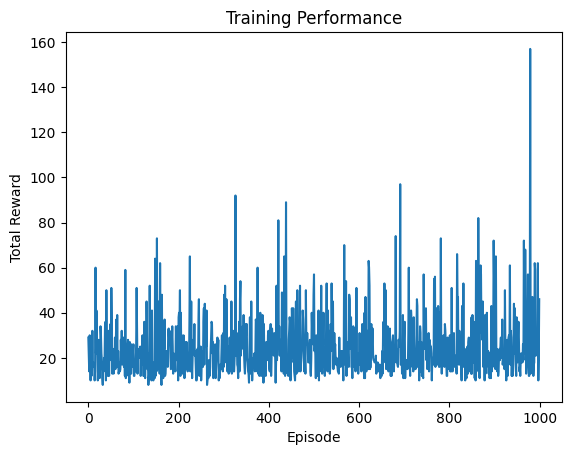

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-49
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 14 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 14 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-49/metadata


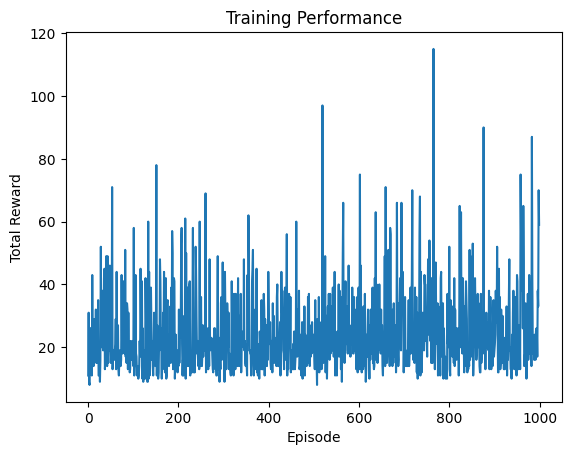

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-50
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 7 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 7 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-50/metadata


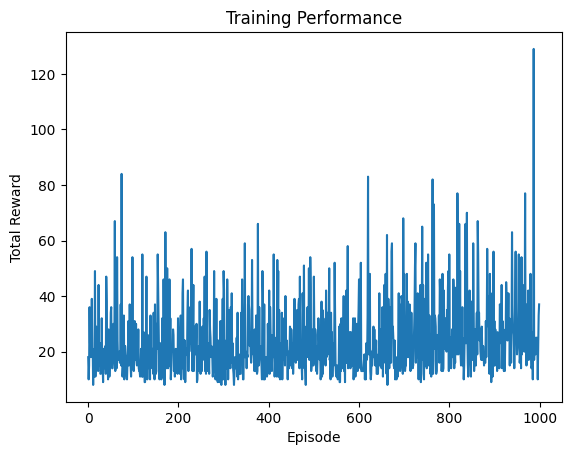

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-51
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 8 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 8 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-51/metadata


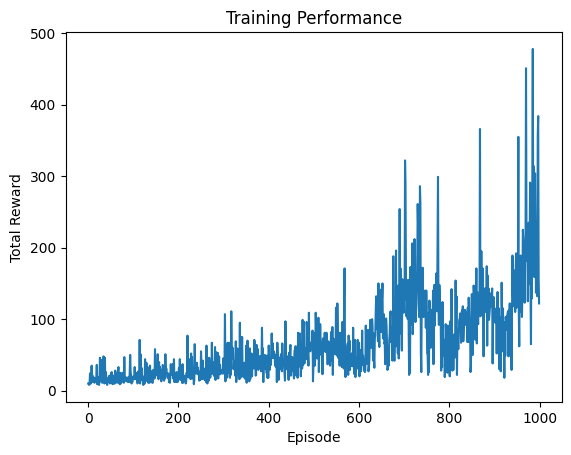

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-52
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 12 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-52/metadata


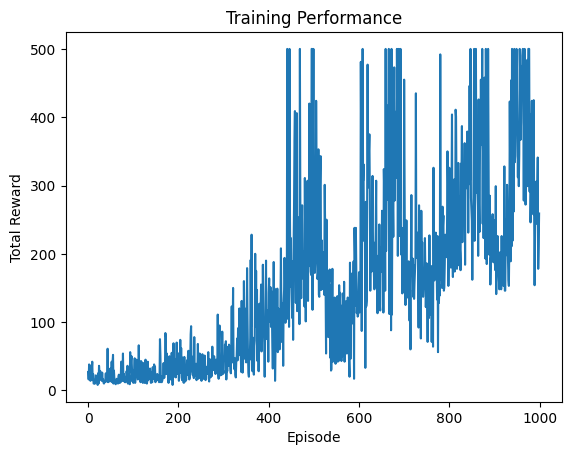

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-53
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 9 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-53/metadata


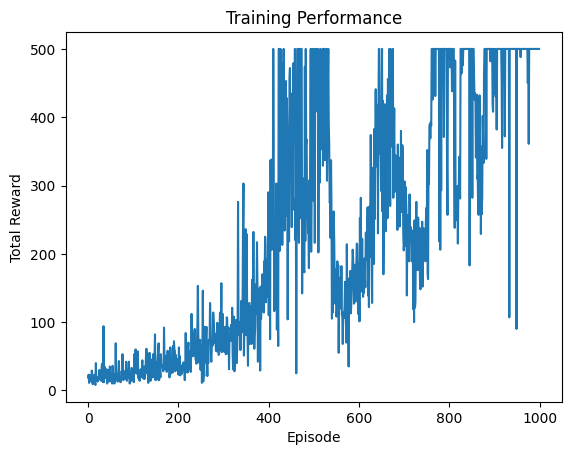

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-54
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 139 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 139 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-54/metadata


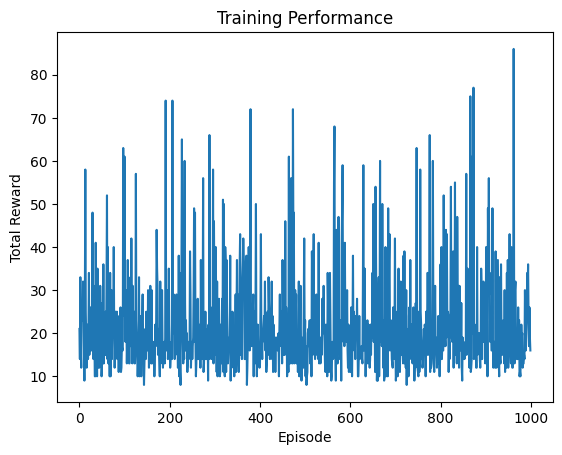

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-55
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 140 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 140 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-55/metadata


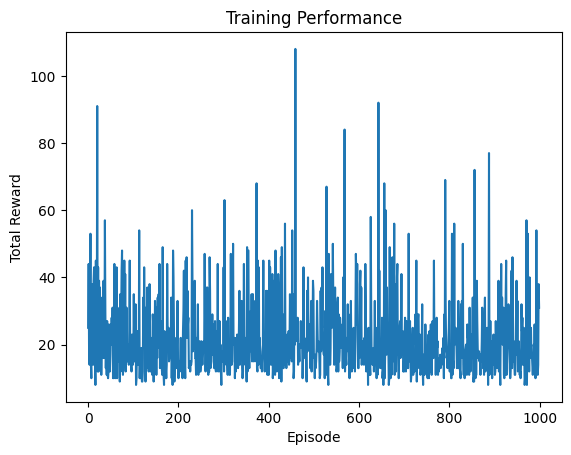

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-56
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 186 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 186 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-56/metadata


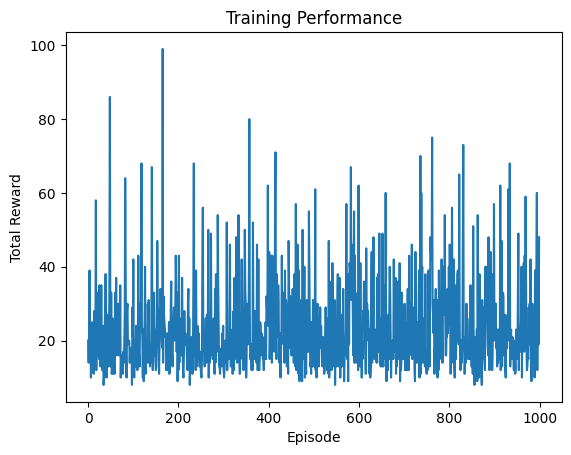

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-57
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 185 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 185 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-57/metadata


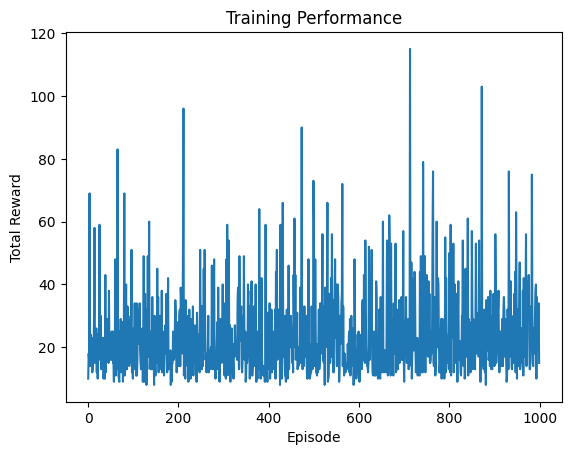

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-58
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 13 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 13 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-58/metadata


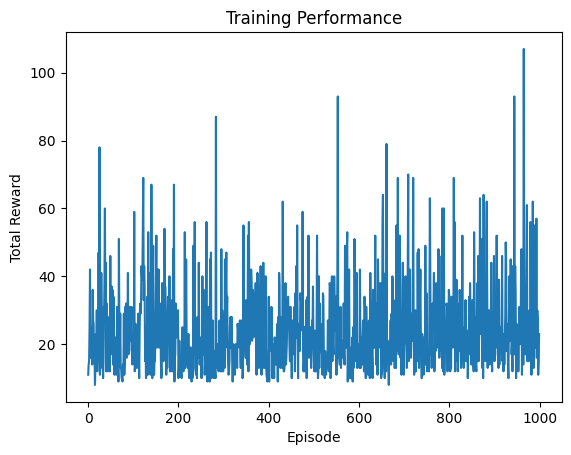

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-59
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 157 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 157 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-59/metadata


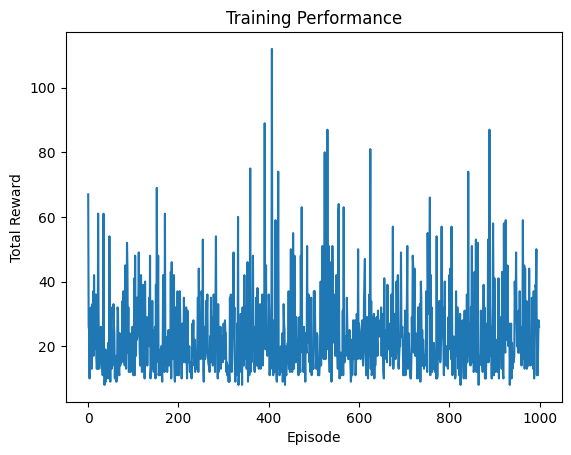

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-60
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 15 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 15 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-60/metadata


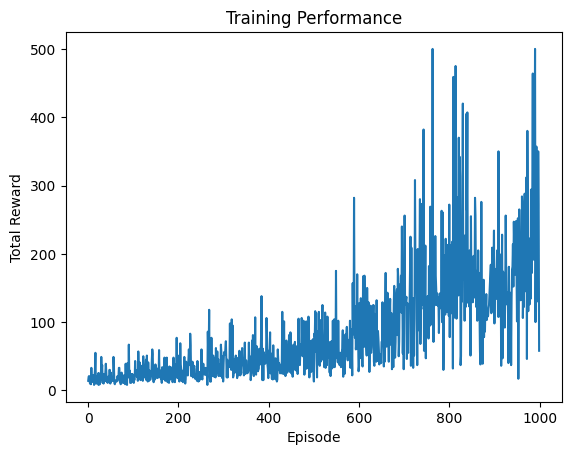

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-61
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 3 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-61/metadata


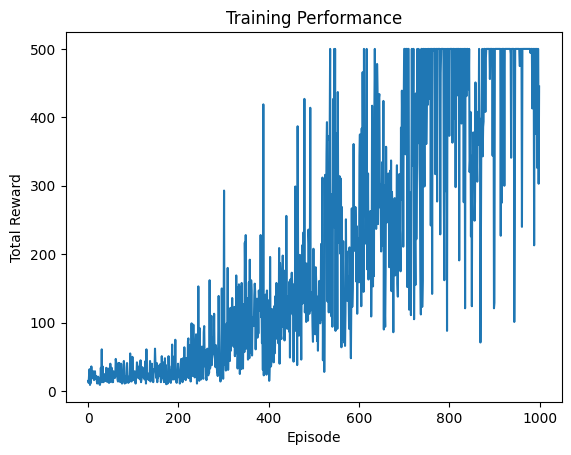

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-62
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 6 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 6 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-62/metadata


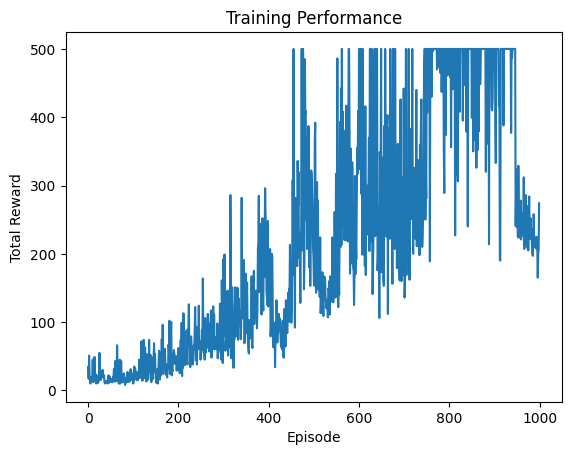

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-63
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 80 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 80 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-63/metadata


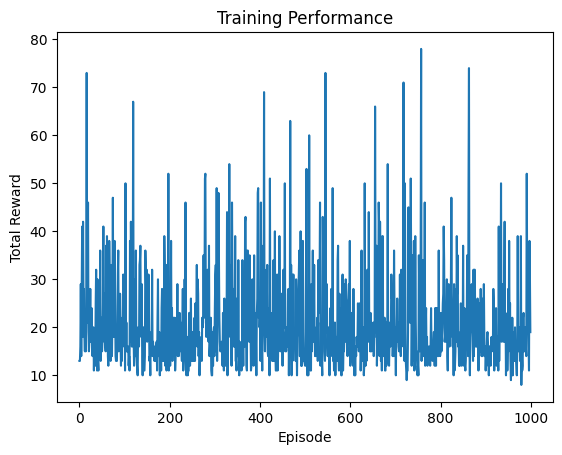

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-64
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 219 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 219 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-64/metadata


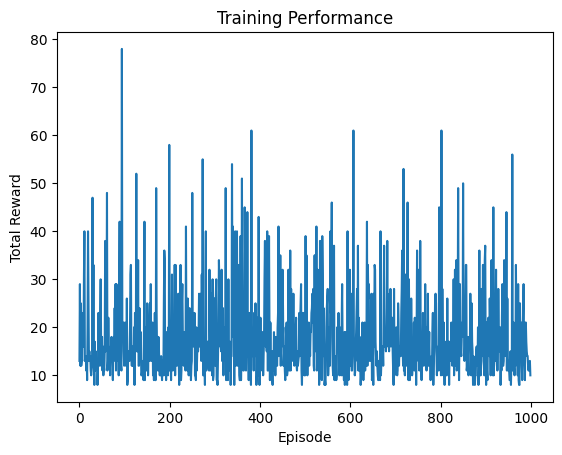

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-65
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 69 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 69 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-65/metadata


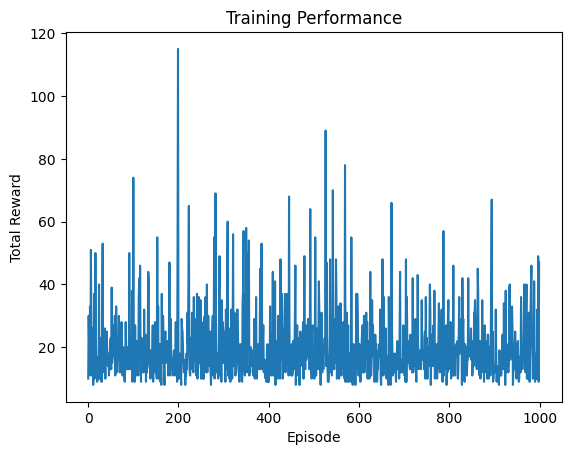

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-66
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 34 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 34 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-66/metadata


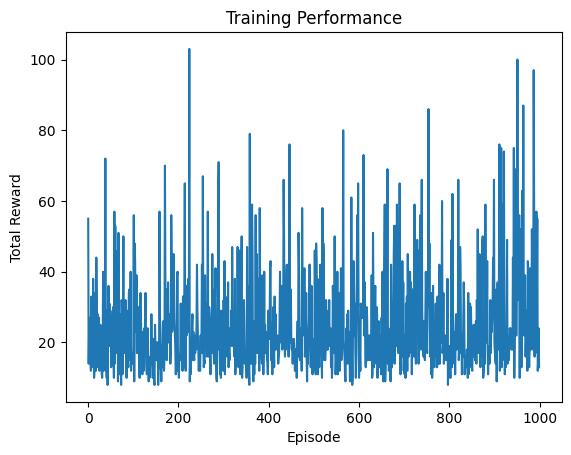

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-67
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 241 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 241 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-67/metadata


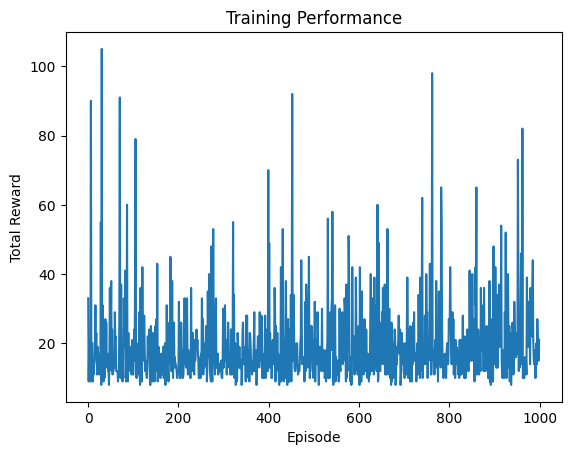

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-68
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 99 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 99 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-68/metadata


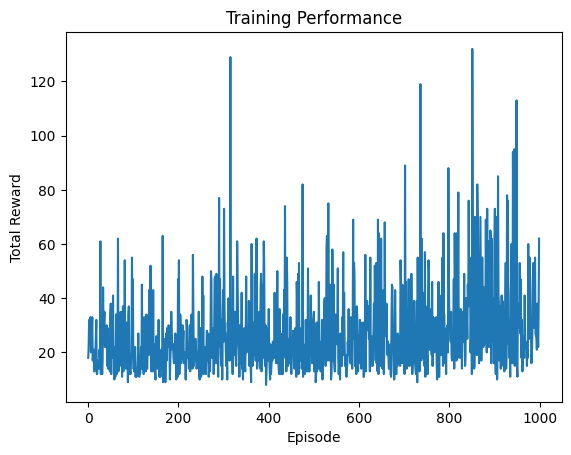

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-69
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 10 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-69/metadata


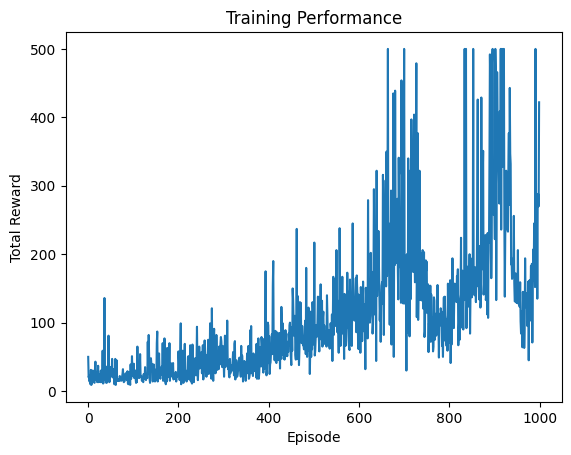

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-70
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 4 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 4 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-70/metadata


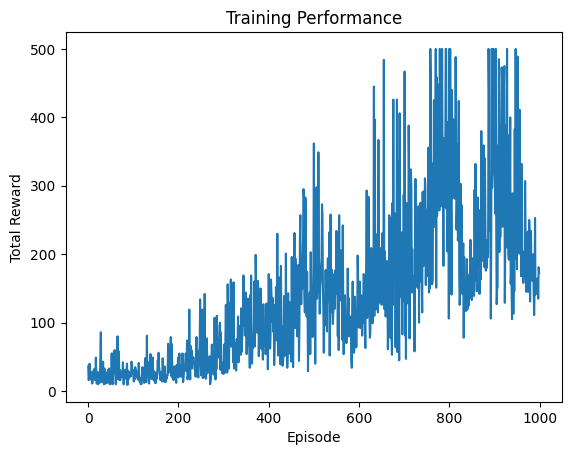

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-71
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 9 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-71/metadata


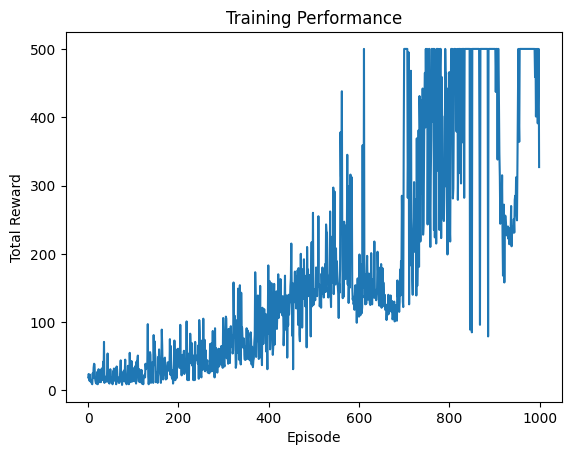

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-72
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 111 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 111 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-72/metadata


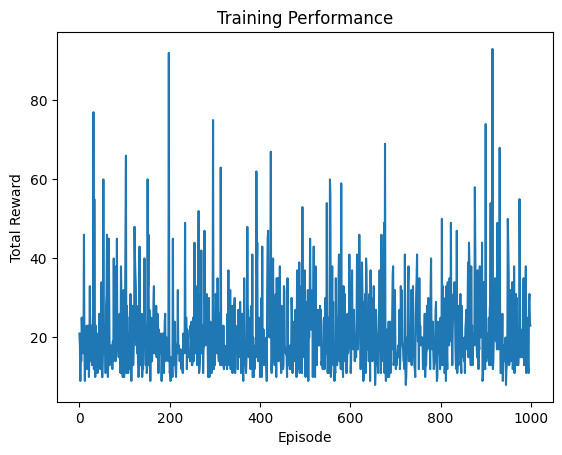

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-73
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 190 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 190 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-73/metadata


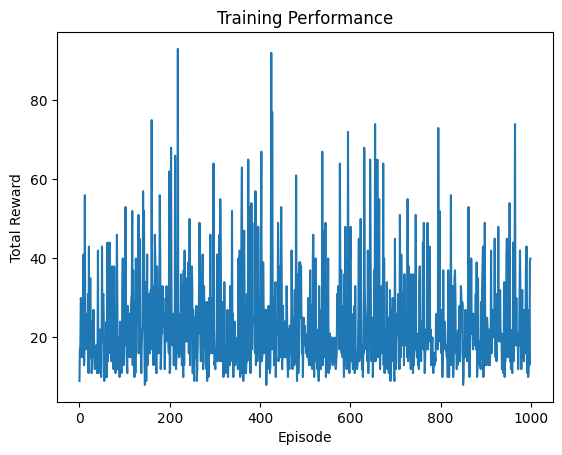

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-74
Using device: cpu
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 129 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 129 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/EnergyGridRL/REINFORCE-cartpole/e/RCART-74/metadata


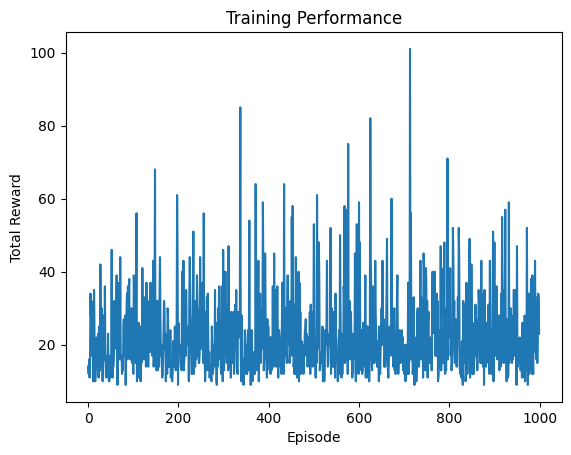

In [ ]:
learning_rates=[1e-4,9.8e-4,1e-6]
gammas=[0.9,0.95,0.99]
for i in range(3):
    for lr in learning_rates:
        for gamma in gammas:
            mainCartPole(lr,gamma)